# Chest X-Ray Medical Diagnosis with Deep Learning

In [9]:
%%bash
tar -czf week_1.tar.gz "W1A1"

tar: W1A1: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


<img src="images/xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">

__Welcome to the first assignment of AI for Medical Diagnosis!__ 

In this assignment you will explore medical image diagnosis by building a state-of-the-art chest X-ray classifier using Keras. 

The assignment will walk through some of the steps of building and evaluating this deep learning classifier model. In particular, you will:
- Pre-process and prepare a real-world X-ray dataset.
- Use transfer learning to retrain a DenseNet model for X-ray image classification.
- Learn a technique to handle class imbalance
- Measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve.
- Visualize model activity using GradCAMs.

In completing this assignment you will learn about the following topics: 

- Data preparation
  - Visualizing data.
  - Preventing data leakage.
- Model Development
  - Addressing class imbalance.
  - Leveraging pre-trained models using transfer learning.
- Evaluation
  - AUC and ROC curves.

## Table of Contents

- [1. Import Packages and Functions](#1)
- [2. Load the Datasets](#2)
    - [2.1 Loading the Data](#2-1)
    - [2.2 Preventing Data Leakage](#2-2)
        - [Exercise 1 - check for Leakage](#Ex-1)
    - [2.3 Preparing Images](#2-3)
- [3. Model Development](#3)
    - [3.1 Addressing Class Imbalance](#3-1)
        - [Exercise 2 - compute Class Frequencies](#Ex-2)
        - [Exercise 3 - get Weighted Loss](#Ex-3)
    - [3.2 DenseNet121](#3-2)
- [4. Training (Optional)](#4)
    - [4.1 Training on the Larger Dataset](#4-1)
- [5. Prediction and Evaluation](#5)
    - [5.1 ROC Curve and AUROC](#5-1)
    - [5.2 Visualizing Learning with GradCAM](#5-2)

<a name='1'></a>
## 1. Import Packages and Functions

We'll make use of the following packages:
- `numpy` and `pandas` is what we'll use to manipulate our data
- `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization
- `util` will provide the locally defined utility functions that have been provided for this assignment

We will also use several modules from the `keras` framework for building deep learning models.

Run the next cell to import all the necessary packages.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util
from public_tests import *
from test_utils import *

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


<a name='2'></a>
## 2. Load the Datasets

For this assignment, we will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
You can download the entire dataset for free [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). 
- We have provided a ~1000 image subset of the images for you.
- These can be accessed in the folder path stored in the `IMAGE_DIR` variable.

The dataset includes a CSV file that provides the labels for each X-ray. 

To make your job a bit easier, we have processed the labels for our small sample and generated three new files to get you started. These three files are:

1. `nih/train-small.csv`: 875 images from our dataset to be used for training.
1. `nih/valid-small.csv`: 109 images from our dataset to be used for validation.
1. `nih/test.csv`: 420 images from our dataset to be used for testing. 

This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

#### Sidebar on meaning of 'class'
It is worth noting that the word **'class'** is used in multiple ways is these discussions. 
- We sometimes refer to each of the 14 pathological conditions that are labeled in our dataset as a class. 
- But for each of those pathologies we are attempting to predict whether a certain condition is present (i.e. positive result) or absent (i.e. negative result). 
    - These two possible labels of 'positive' or 'negative' (or the numerical equivalent of 1 or 0) are also typically referred to as classes. 
- Moreover, we also use the term in reference to software code 'classes' such as `ImageDataGenerator`.

As long as you are aware of all this though, it should not cause you any confusion as the term 'class' is usually clear from the context in which it is used.

<a name='2-1'></a>
### 2.1 Loading the Data
Let's open these files using the [pandas](https://pandas.pydata.org/) library

In [2]:
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")

test_df = pd.read_csv("data/nih/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-2'></a>
### 2.2 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

<a name='Ex-1'></a>
### Exercise 1 - Check for Leakage
In the cell below, write a function to check whether there is leakage between two datasets. We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Make use of python's set.intersection() function. </li>
    <li> In order to match the automatic grader's expectations, please start the line of code with <code>df1_patients_unique...[continue your code here]</code> </li>

</ul>
</p>

In [4]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patient_overlap = list(df1_patients_unique.intersection(df2_patients_unique))
     
    patients_in_both_groups = len(patient_overlap)

    if patients_in_both_groups > 0:
        return True
    
    return False

In [5]:
### do not edit this code cell    
check_for_leakage_test(check_for_leakage)

Test Case 1

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True 
-------------------------------------
Test Case 2

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           3
1           4
2           5
leakage output: False 

 All tests passed.


##### Expected output

```Python
Test Case 1

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True 
-------------------------------------
Test Case 2

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           3
1           4
2           5
leakage output: False
```
```
 All tests passed.
```

Run the next cell to check if there are patients in both train and test or in both valid and test.

In [6]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


##### Expected output

```Python
leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False
```

<a name='2-3'></a>
### 2.3 Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Keras documentation, we have implemented the generator for you. There are a few things to note: 
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be 320px by 320px

In [7]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

#### Build a separate generator for valid and test sets

Now we need to build a new generator for validation and testing data. 

**Why can't we use the same generator as for the training data?**

Look back at the generator we wrote for the training data. 
- It normalizes each image **per batch**, meaning that it uses batch statistics. 
- We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). 
- Knowing the average per batch of test data would effectively give our model an advantage.  
    - The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics **computed from the training set**. 
* We implement this in the function below. 
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. 
* However, since this is extremely large, that would be very time consuming. 
* In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [8]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [9]:
IMAGE_DIR = "data/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Let's peek into what the generator gives our model during training and validation. We can do this by calling the `__get_item__(index)` function:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


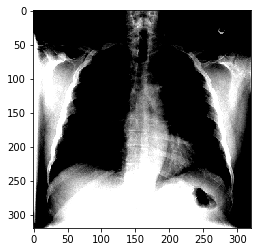

In [10]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3. Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

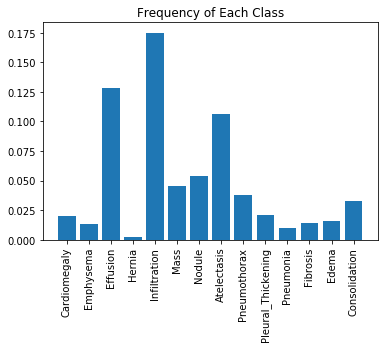

In [11]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

<a name='Ex-2'></a>
### Exercise 2 - Compute Class Frequencies
Complete the function below to calculate these frequences for each label in our dataset.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Use numpy.sum(a, axis=), and choose the axis (0 or 1) </li>
</ul>
</p>


In [42]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    positive_frequencies = []
    negative_frequencies = []
        
    for label in range(len(labels[0])): #for every disease/class     
    
        positive_freq = np.mean(labels[:,label])
        neg_freq = 1 - positive_freq

        positive_frequencies.append(positive_freq)
        negative_frequencies.append(neg_freq)


    
    ### END CODE HERE ###
    return np.asarray(positive_frequencies), np.asarray(negative_frequencies)
    

In [43]:
test = np.array([[1, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1], [1, 0, 1]])
print(len(test[0]))
print(test[:,0])
print(np.mean(test[:,2]))
print(test[1][2])

compute_class_freqs(test)

3
[1 0 1 1 1]
0.8
1


(array([0.8, 0.4, 0.8]), array([0.2, 0.6, 0.2]))

In [44]:
### do not edit this code cell       
compute_class_freqs_test(compute_class_freqs)

Labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]

Pos Freqs:  [0.8 0.4 0.8]
Neg Freqs:  [0.2 0.6 0.2] 

 All tests passed.


##### Expected output

```Python
Labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]

Pos Freqs:  [0.8 0.4 0.8]
Neg Freqs:  [0.2 0.6 0.2] 
```
```
 All tests passed. 
```

Now we'll compute frequencies for our training data.

In [15]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

##### Expected output

```Python
array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])
```


Let's visualize these two contribution ratios next to each other for each of the pathologies:

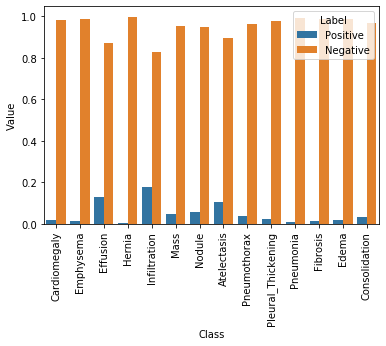

In [16]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [17]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

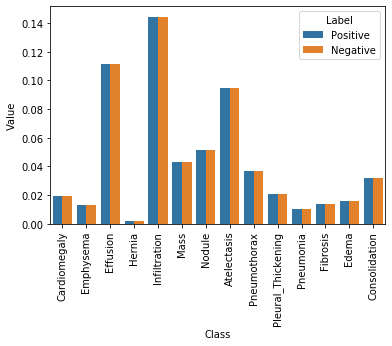

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

<a name='Ex-3'></a>
### Exercise 3 - Get Weighted Loss
Fill out the `weighted_loss` function below to return a loss function that calculates the weighted loss for each batch. Recall that for the multi-class loss, we add up the average loss for each individual class. Note that we also want to add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.

##### Note
Please use Keras functions to calculate the mean and the log.

- [Keras.mean](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/backend/mean)
- [Keras.log](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/backend/log)

In [37]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
        
        return loss
        ### END CODE HERE ###
    return weighted_loss

In [38]:
# test with a large epsilon in order to catch errors. 
# In order to pass the tests, set epsilon = 1
epsilon = 1

### do not edit anything below
sess = K.get_session()
get_weighted_loss_test(get_weighted_loss, epsilon, sess)

y_true:
[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:
[0.25 0.25 0.5 ]

w_n:
[0.75 0.75 0.5 ]

y_pred_1:
[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If you weighted them correctly, you'd expect the two losses to be the same.
With epsilon = 1, your losses should be, L(y_pred_1) = -0.4956203 and L(y_pred_2) = -0.4956203

Your outputs:

L(y_pred_1) =  -0.4956203
L(y_pred_2) =  -0.4956203
Difference: L(y_pred_1) - L(y_pred_2) =  0.0 

 All tests passed.


##### Expected output

with epsilon = 1
```Python
Your outputs:

L(y_pred_1) =  -0.4956203
L(y_pred_2) =  -0.4956203
Difference: L(y_pred_1) - L(y_pred_2) =  0.0 
```
```
 All tests passed.   
```

If you are missing something in your implementation, you will see a different set of losses for `L(y_pred_1)` and `L(y_pred_2)` (even though `L(y_pred_1)` and `L(y_pred_2)` will be the same).

<a name='3-2'></a>
### 3.2 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [39]:
# create the base pre-trained model
base_model = DenseNet121(weights='models/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

<a name='4'></a>
## 4. Training (Optional)

With our model ready for training, we will use the `model.fit()` function in Keras to train our model. 
- We are training on a small subset of the dataset (~1%).  
- So what we care about at this point is to make sure that the loss on the training set is decreasing.

Since training can take a considerable time, for pedagogical purposes we have chosen not to train the model here but rather to load a set of pre-trained weights in the next section. However, you can use the code shown below to practice training the model locally on your machine or in Colab.

**NOTE:** Do not run the code below on the Coursera platform as it will exceed the platform's memory limitations.

Python Code for training the model:

```python
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()
```

<a name='4-1'></a>
### 4.1 Training on the Larger Dataset

Given that the original dataset is 40GB+ in size and the training process on the full dataset takes a few hours, we have trained the model on a GPU-equipped machine for you and provided the weights file from our model (with a batch size of 32 instead) to be used for the rest of this assignment. 

The model architecture for our pre-trained model is exactly the same, but we used a few useful Keras "callbacks" for this training. Do spend time to read about these callbacks at your leisure as they will be very useful for managing long-running training sessions:

1. You can use `ModelCheckpoint` callback to monitor your model's `val_loss` metric and keep a snapshot of your model at the point. 
2. You can use the `TensorBoard` to use the Tensorflow Tensorboard utility to monitor your runs in real-time. 
3. You can use the `ReduceLROnPlateau` to slowly decay the learning rate for your model as it stops getting better on a metric such as `val_loss` to fine-tune the model in the final steps of training.
4. You can use the `EarlyStopping` callback to stop the training job when your model stops getting better in it's validation loss. You can set a `patience` value which is the number of epochs the model does not improve after which the training is terminated. This callback can also conveniently restore the weights for the best metric at the end of training to your model.

You can read about these callbacks and other useful Keras callbacks [here](https://keras.io/callbacks/).

Let's load our pre-trained weights into the model now:

In [41]:
model.load_weights("models/nih/pretrained_model.h5")

<a name='5'></a>
## 5. Prediction and Evaluation

Now that we have a model, let's evaluate it using our test set. We can conveniently use the `predict_generator` function to generate the predictions for the images in our test set.

**Note:** The following cell can take about 4 minutes to run.

In [42]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

<a name='5-1'></a>
### 5.1 ROC Curve and AUROC
We'll cover topic of model evaluation in much more detail in later weeks, but for now we'll walk through computing a metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. This is also referred to as the AUROC value, but you will see all three terms in reference to the technique, and often used almost interchangeably. 

For now, what you need to know in order to interpret the plot is that a curve that is more to the left and the top has more "area" under it, and indicates that the model is performing better.

We will use the `util.get_roc_curve()` function which has been provided for you in `util.py`. Look through this function and note the use of the `sklearn` library functions to generate the ROC curves and AUROC values for our model. 

- [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

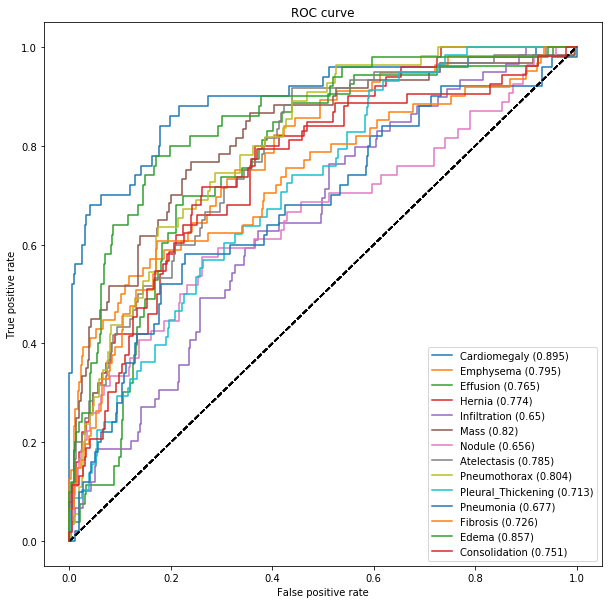

In [43]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

You can compare the performance to the AUCs reported in the original ChexNeXt paper in the table below: 

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">

This method does take advantage of a few other tricks such as self-training and ensembling as well, which can give a significant boost to the performance.

For details about the best performing methods and their performance on this dataset, we encourage you to read the following papers:
- [CheXNet](https://arxiv.org/abs/1711.05225)
- [CheXpert](https://arxiv.org/pdf/1901.07031.pdf)
- [ChexNeXt](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002686)

<a name='5-2'></a>
### 5.2 Visualizing Learning with GradCAM 

One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). 

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM). 
- Class activation maps are useful for understanding where the model is "looking" when classifying an image. 

In this section we will use a [GradCAM's](https://arxiv.org/abs/1610.02391) technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer. Look at the `util.compute_gradcam` which has been provided for you in `util.py` to see how this is done with the Keras framework. 

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. 
- However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

In [44]:
df = pd.read_csv("data/nih/train-small.csv")
IMAGE_DIR = "data/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Now let's look at a few specific images.

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax


KeyboardInterrupt: 

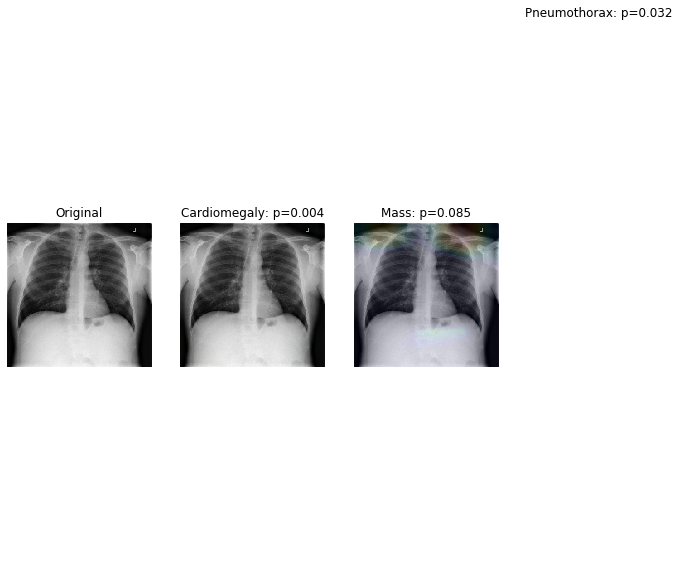

In [45]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

Congratulations, you've completed the first assignment of course one! You've learned how to preprocess data, check for data leakage, train a pre-trained model, and evaluate using the AUC. Great work!